In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # on NERSC filelocking is not allowed
import h5py
import tensorflow as tf
# Make notebook run on other GPUS. GPT's solution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# gpus = tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices(gpus[2], 'GPU')  # change 1 to 0, 2, 3 as needed
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# import tensorflow.math as tfmath
import tensorflow.keras as keras
# from scipy.optimize imporjun26t curve_fit
# from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk
# from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, LeakyReLU, ReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.metrics import Precision
# # from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm # These don't seem to be used
# # from qkeras import quantized_relu, quantized_bits
from tensorflow.keras.regularizers import l1, l2, l1_l2

2025-07-07 13:23:45.897441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-07 13:23:47.401193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load data
home_path = "/global/cfs/cdirs/m2616/jananinf/projsIO/VAE_FS/" # Updated to NERSC
file_path = home_path + "preprocessed_SNL_data.h5"
with h5py.File(file_path, 'r') as hf:           # Shapes:
    X_train = hf['X_train'][:]                  # (3200000, 57)
    X_test  = hf['X_test'][:]                   # (800000,  57)
    Ato4l_data  = hf['Ato4l_data'][:]           # (55969,   57) Signal data? 
    hToTauTau_data  = hf['hToTauTau_data'][:]   # (691283,  57)
    hChToTauNu_data  = hf['hChToTauNu_data'][:] # (760272,  57)
    leptoquark_data = hf['leptoquark_data'][:]  # (340544,  57)
    print("Data loaded from preprocessed_SNL_data.h5")

Data loaded from preprocessed_SNL_data.h5


In [3]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    


In [ ]:
def Qmake_encoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    """
    Makes encoder

    Parameters
    ----------
    input_dim : int
        size of input layer
    h_dim_[X] : int
        size of hidden layer X
    latent_dim : int
        size of latent layer
    """

    # What is this and why? ----------------------------------------------------
    # update: well we don't want to be too different from Kenny's repo afterall. Initialization in layers are kept to stay consistent with Kenny. Batch normalization removed for same reason.
    l2_factor = 1e-3 
    # --    

    # Input layer
    inputs = keras.Input(shape=(input_dim))

    # Hidden layer 1 -----------------------------------------------------------
    x = Dense(h_dim_1,
             kernel_initializer=keras.initializers.HeNormal(seed=None), 
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor), # This is where the l2_factor is used.
             name = "enc_dense1")(inputs)
    x = LeakyReLU(name="enc_Lrelu1")(x)
    # ---

    # Hidden Layer 1 -----------------------------------------------------------
    x = Dense(h_dim_2,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "enc_dense2")(x)
    x = LeakyReLU(name="enc_Lrelu2")(x)
    # ---

    # Latent layer -------------------------------------------------------------
    # No activation. 
    z_mean=Dense(latent_dim, name='z_mean',
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros(),
                  kernel_regularizer=l1_l2(l1=0, l2=l2_factor)
                )(x)
    z_logvar=Dense(latent_dim, name='z_log_var',
                      kernel_initializer=keras.initializers.Zeros(),
                      bias_initializer=keras.initializers.Zeros(),
                      kernel_regularizer=l1_l2(l1=0, l2=l2_factor)
                    )(x)
     # Comparing this to eq 2 in arXiv: 2108.03986 z_log_var = log(sigma**2)
    z=Sampling()([z_mean,z_logvar])
    # ---


    encoder = keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder


def Qmake_decoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    """ 
    Makes decoder

    Parameters
    ----------
    input_dim : int
        size of input layer
    h_dim_[X] : int
        size of hidden layer X
    latent_dim : int
        size of latent layer
    """
    l2_factor = 1e-3
    # Input layer -------
    inputs=keras.Input(shape=(latent_dim)) 

    # Hiden layer 1 (3 total, not counting latent) -------
    x = Dense(h_dim_2,
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor)
                   )(inputs)
    x = LeakyReLU(name="dec_Lrelu3")(x)
    # --


    # Hidden layer 2( 4 total, not counting laten) -----
    x = Dense(h_dim_1,
    # ? ----  #    activation='relu', # Why ReLU over papers leaky ReLU?
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor)
                   )(x)
    x = LeakyReLU(name="dec_Lrelu4")(x)
    # --

    x = Dense(input_dim,
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor)
                   )(x)
    y = LeakyReLU(name="dec_Lrelu5")(x)
    decoder=keras.Model(inputs, y,name='decoder')
    return decoder

In [5]:
INPUT_SZ = 57
H1_SZ = 32
H2_SZ = 16
LATENT_SZ = 3
enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
enc.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 enc_dense1 (Dense)             (None, 32)           1856        ['input_1[0][0]']                
                                                                                                  
 enc_Lrelu1 (LeakyReLU)         (None, 32)           0           ['enc_dense1[0][0]']             
                                                                                                  
 enc_dense2 (Dense)             (None, 16)           528         ['enc_Lrelu1[0][0]']             
                                                                                            

2025-07-07 13:24:01.411825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2025-07-07 13:24:01.413386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2025-07-07 13:24:01.415027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
2025-07-07 13:24:01.416654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

In [6]:
dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
dec.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 16)                64        
                                                                 
 dec_Lrelu3 (LeakyReLU)      (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dec_Lrelu4 (LeakyReLU)      (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 57)                1881      
                                                                 
 dec_Lrelu5 (LeakyReLU)      (None, 57)                0   

In [7]:
# def _custom_MSE(reconstruction, data):
#     # "We use a dataset with standardized p_T as a target so that all quantities are O(1)" arXiv: 2108.03986 

#     # Q: is the input also standardized?
    
#     loss = keras.losses.mse(data, reconstruction)
#     return loss

def _custom_MSE(masked_data, masked_reconstruction):
#     jet_scale = 256/64
#     tau_scale = 128/64
#     muon_scale = 32/64
#     met_scale = 512/64
#     em_scale = 128/64
    jet_scale = 1
    tau_scale = 1
    muon_scale = 1
    met_scale = 1
    em_scale = 1
    # Define the indices and their corresponding scale factors
    scale_dict = {
        0: met_scale,
        3: em_scale, 6: em_scale, 9: em_scale, 12: em_scale,
        15: tau_scale, 18: tau_scale, 21: tau_scale, 24: tau_scale,
        27: jet_scale, 30: jet_scale, 33: jet_scale, 36: jet_scale, 39: jet_scale, 42: jet_scale,
        45: muon_scale, 48: muon_scale, 51: muon_scale, 54: muon_scale
    }

    # Create the scaling tensor
    scale_tensor = tf.ones_like(masked_data)
    for index, factor in scale_dict.items():
        index_mask = tf.one_hot(index, depth=tf.shape(masked_data)[-1])
        scale_tensor += index_mask * (factor - 1)

    # Apply scaling
    scaled_data = masked_data * scale_tensor
    scaled_reconstruction = masked_reconstruction * scale_tensor

    # Hardcoded lists for eta and phi indices
    eta_indices = [4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55]
    phi_indices = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56]

    batch_size = tf.shape(scaled_reconstruction)[0]
    
    # Set only the first eta (index 1) to zero
    indices = tf.stack([tf.range(batch_size), tf.ones(batch_size, dtype=tf.int32)], axis=1)
    updates = tf.zeros(batch_size)
    scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
    # Apply constraints to eta
    for i in eta_indices:
        indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
        updates = 3 * tf.tanh(scaled_reconstruction[:, i] / 3)
        scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
    # Apply constraints to phi
    for i in phi_indices:
        indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
        updates = 3.14159265258979 * tf.tanh(scaled_reconstruction[:, i] / 3.14159265258979)
        scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
        
    # Calculate MSE using keras.losses.mse
    mse = keras.losses.mse(scaled_data, scaled_reconstruction)

    # Take the sum across all dimensions
    return tf.reduce_mean(mse)

class VAE_Model(keras.Model):
    def __init__(self, encoder, decoder, steps_per_epoch=3125,cycle_length=10, min_beta=0.1, max_beta=0.85, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        # beta turning part?
        self.cycle_length = tf.cast(cycle_length, tf.float32)
        self.steps_per_epoch = steps_per_epoch
        self.min_beta = tf.cast(min_beta, tf.float32)
        self.max_beta = tf.cast(max_beta, tf.float32)
        self.beta = tf.Variable(min_beta, dtype=tf.float32)
        self.beta_tracker = keras.metrics.Mean(name="beta")

        # per keras VAE example https://keras.io/examples/generative/vae/
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.beta_tracker,
        ]

    def cyclical_annealing_beta(self, epoch):
        # is this the beta tuning?  
        cycle = tf.floor(1.0 + epoch / self.cycle_length)
        x = tf.abs(epoch / self.cycle_length - cycle + 1)
        return self.min_beta + (self.max_beta - self.min_beta) * tf.minimum(x, 1.0)
    

    def train_step(self, data):
        # Is this the beta tuning?
        epoch = tf.cast(self.optimizer.iterations / self.steps_per_epoch, tf.float32)
        
        # Update beta
        self.beta.assign(self.cyclical_annealing_beta(epoch))

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # here we shove in our custom reconstructionn loss function
            # Ignore zero-padded entries. 
            mask = K.cast(K.not_equal(data, 0), K.floatx()) 
            reconstruction_loss = _custom_MSE(mask*reconstruction, mask*data)
            reconstruction_loss *=(1-self.beta)

            # This is just standard Kullback-Leibler diversion loss. I think this can stay.
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta
            # Now let solve what beta is
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": self.beta,
        }
    
    # Since we overrode train_step we need test_step
    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = _custom_MSE(mask*data, mask*reconstruction)
        reconstruction_loss *= (1 - self.beta)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)        
        kl_loss *=self.beta
        
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "beta": self.beta,
        }


    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        } 

    # need to define the loss

### Training

In [8]:
NUM_EPOCHS = 100
BATCH_SIZE = 16384
STOP_PATIENCE = 15
LR_PATIENCE = 10
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
vae = VAE_Model(enc, dec, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.8)
opt = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1000)
vae.compile(optimizer=opt) # Not sure what weighted_mse is doing.



In [9]:
# looks like early_stopping is needed for val_loss
early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

In [ ]:
train = False
if train:
    history = vae.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping,reduce_lr], shuffle=True)


In [11]:
save = False
# Last save is in attempt 1. New save should go to attempt 2
save_path = home_path+'/VAE_trainings/attempt1/'
if save:
    vae.save_weights(filepath= save_path, save_format='tf')

# Attempt History. The original code for each folder should also be tied to the commits. 
# 0: no weighted MSE, no call_backs
# 1: adding ReduceLRonPlatueau and early_stopping and the test_step

In [12]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by your model.fit() call

# Extract the loss values
total_loss = history.history['loss']
reco_loss = history.history['reconstruction_loss']
kl_loss = history.history['kl_loss']
val_total_loss = history.history['val_loss']
val_reco_loss = history.history['val_reconstruction_loss']
val_kl_loss = history.history['val_kl_loss']

# Create a new figure
plt.figure(figsize=(12, 8))

# Plot training losses
plt.plot(total_loss, label='Total Loss', color='blue')
plt.plot(reco_loss, label='Reconstruction Loss', color='green')
plt.plot(kl_loss, label='KL Loss', color='red')

# Plot validation losses
plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

# Customize the plot
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

NameError: name 'history' is not defined

##### Reload from the latest save

In [13]:
new_enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
new_dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
new_VAE = VAE_Model(new_enc, new_dec)
new_VAE.load_weights(save_path)
just_enc = new_VAE.get_layer("encoder") # We only need encoder output

##### Encode data, calculate anomaly score and plot ROC

In [19]:
# helper functions. These are intended as the AD metric funciton in calc_anomaly_scores
def AD_score_KL(z_mean, z_log_var):
    kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    # Comparing this to eq 2 in arXiv: 2108.03986 z_log_var = log(sigma**2)
    return kl_loss


def AD_score_CKL(z_mean, _): # z_log_var not used
    CKL = np.mean(z_mean**2)
    return CKL 

def AD_score_Rz(z_mean, z_log_var):
    return z_mean**2/np.exp(z_log_var)

def calc_anomaly_scores(data, encoder: keras.Model, AD_metric, debug = True):
    """
    Parameters:
    -----------
    debug: Optional bool to skip latent space vectors that produce infinities.
    Currently set to true as it seems only 2 specific cases are affected
    """
    dat_encoded = np.array(encoder.predict(data))[0] # This outputs shape (3, len(X_test), 3). Can't find satisfactory explanation for this behavior. (len(X_test), 3) makes sense. (3, len, 3) does not
    # Kenny only uses the first list so we'll follow that convention.
    # has shape (len(data), 3), where col 1 is z_mean, 2 is z_log_var and z. This is by design of encoder.
    scores = np.zeros(len(data))
    for i in range(len(scores)):
        z_mean, z_log_var = dat_encoded[i][0], dat_encoded[i][1]
        score = AD_metric(z_mean, z_log_var)
        if debug and (score == np.inf):
            print("RUNTIME WARNING: inf encountered. Skipping these values\n"
                  + f"z_mean: {z_mean}\n"
                  + f"z_log_var: {z_log_var}")
            continue
        scores[i] = score

    return scores

##### Calculate Anamoly scores

In [ ]:
def get_truth_and_scores(encoder, AD_metric, debug=True):
    bg_score = calc_anomaly_scores(X_test, encoder, AD_metric)
    scores = []
    truths = []
    zeros = np.zeros(len(X_test))
    signal_data = [leptoquark_data, Ato4l_data, hChToTauNu_data, hToTauTau_data]

    # Generate Truth and score lists ready for ROC curve calculation
    for dat in signal_data:
        truths.append(np.concatenate((zeros, np.ones(len(dat)))))

        s = calc_anomaly_scores(dat, encoder, AD_metric, debug=debug)
        scores.append(np.concatenate((bg_score,s) ))

    return (truths, scores)

In [ ]:
def plot_rocs(truths, scores, fig_title):
    target_fpr = 1e-5
    tpr_at_target = []
    signal_names_tex = [ # latex version
                    "Leptoquark"
                    , "$A\\rightarrow 4\ell$"
                    , "$h^{\pm}\\rightarrow\\tau \\nu$"
                    , "$h^0\\rightarrow\\tau\\tau$"
                    ]
    signal_names_hum = [ # human readable
                    "Leptoquark"
                    ,"A to 4L"
                    , "h to Tau Nu"
                    , "h to Tau Tau"
                    ]

    for truth, score, l in zip(truths, scores, signal_names_tex):
        fpr, tpr, thresholds = roc_curve(truth, score)
        auc = sk.roc_auc_score(truth, score)
        plt.plot(fpr, tpr, label=l + f": {str(round(auc, 3))}") # plot roc curve



        # Find tpr at fpr target
        idx = np.argmin(np.abs(fpr - target_fpr))
        tpr_at_target.append(tpr[idx])
        
    plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--")
    plt.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")

    # Plot teaks
    plt.loglog()
    plt.legend()
    plt.grid()
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title(fig_title) 
    plt.show()

    for sig_nam, tpr in zip(signal_names_hum, tpr_at_target):
        print(sig_nam + " TPR @ FPR 10e-5 (%): " + f"{tpr*100:.2f}")
    

  156/25000 [..............................] - ETA: 16s   

2025-07-07 13:25:10.581238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1750/1750 [==============================] - 1s 634us/step


/tmp/ipykernel_1249564/3503634157.py:3: RuntimeWarning: overflow encountered in exp
  kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))


RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -68.89347076416016
z_log_var: 90.32584381103516
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -75.19064331054688
z_log_var: 103.67664337158203
21603/21603 [==============================] - 15s 672us/step


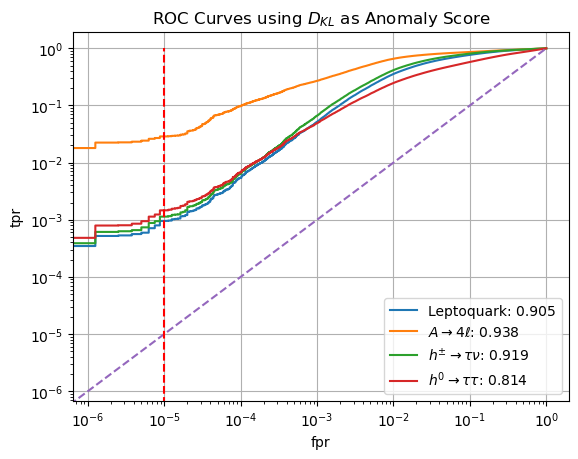

Leptoquark TPR @ FPR 10e-5 (%): 0.10
A to 4L TPR @ FPR 10e-5 (%): 2.87
h to Tau Nu TPR @ FPR 10e-5 (%): 0.11
h to Tau Tau TPR @ FPR 10e-5 (%): 0.15


In [17]:
t, s = get_truth_and_scores(just_enc, AD_score_KL)
plot_rocs(t, s, "ROC Curves using $D_{KL}$ as Anomaly Score")

21603/21603 [==============================] - 14s 632us/step


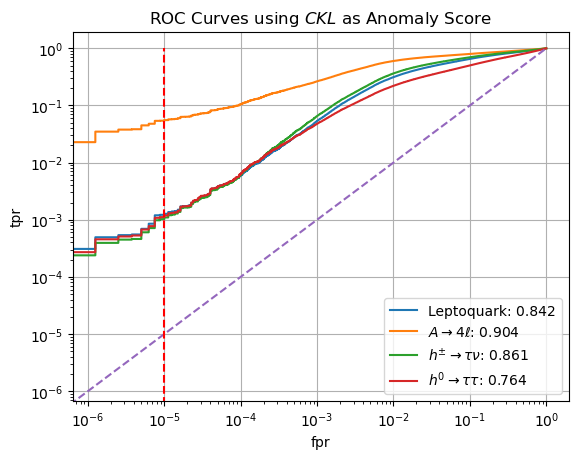

Leptoquark TPR @ FPR 10e-5 (%): 0.12
A to 4L TPR @ FPR 10e-5 (%): 5.41
h to Tau Nu TPR @ FPR 10e-5 (%): 0.10
h to Tau Tau TPR @ FPR 10e-5 (%): 0.11


In [18]:
t, s = get_truth_and_scores(just_enc, AD_score_CKL)
plot_rocs(t, s, "ROC Curves using $CKL$ as Anomaly Score")

10642/10642 [==============================] - 7s 632us/step


/tmp/ipykernel_1249564/3309617845.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  return z_mean**2/np.exp(z_log_var)


RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -55.04864501953125
z_log_var: -116.8426742553711
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 123.64871215820312
z_log_var: -105.5840835571289
1750/1750 [==============================] - 1s 616us/step
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: -59.42531967163086
z_log_var: -104.10490417480469
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 195.35446166992188
z_log_var: -121.83012390136719
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 138.2411651611328
z_log_var: -114.35296630859375
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 143.33221435546875
z_log_var: -122.0279541015625
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 91.79953002929688
z_log_var: -112.79229736328125
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 118.52680206298828
z_log_var: -112.22000885009766
RUNTIME WARNING: inf encountered. 

/tmp/ipykernel_1249564/3309617845.py:13: RuntimeWarning: overflow encountered in exp
  return z_mean**2/np.exp(z_log_var)


23759/23759 [==============================] - 15s 628us/step
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 158.3096923828125
z_log_var: -146.54238891601562
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 175.86517333984375
z_log_var: -118.7422103881836
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 88.35181427001953
z_log_var: -106.06195831298828
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 168.6171112060547
z_log_var: -147.42196655273438
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 42.578346252441406
z_log_var: -106.48068237304688
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 162.80404663085938
z_log_var: -149.67379760742188
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 125.51555633544922
z_log_var: -119.44499206542969
RUNTIME WARNING: inf encountered. Skipping these values
z_mean: 173.18736267089844
z_log_var: -106.65959167480469
RUNTIME WARNING: inf encounter

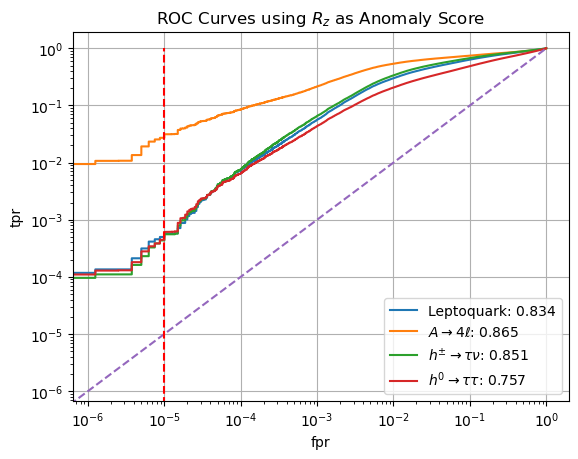

Leptoquark TPR @ FPR 10e-5 (%): 0.05
A to 4L TPR @ FPR 10e-5 (%): 2.71
h to Tau Nu TPR @ FPR 10e-5 (%): 0.04
h to Tau Tau TPR @ FPR 10e-5 (%): 0.04


In [20]:
t, s = get_truth_and_scores(just_enc, AD_score_Rz)
plot_rocs(t, s, "ROC Curves using $R_z$ as Anomaly Score")